In [135]:
import pickle
with open('sup_loaded_data_1000.pickle', 'rb') as f:
    sup_DATA = pickle.load(f)

In [1]:
import pickle
with open('sup_loaded_data_2000.pickle', 'rb') as f:
    sup_DATA = pickle.load(f)

In [2]:
len(sup_DATA[1]['MEL'])

1989

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential,Model
from keras.layers import concatenate,Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json
from sklearn.metrics import roc_curve
from keras.utils import np_utils
from tqdm import tqdm
import pandas as pd
import numpy as np
import librosa 
import librosa.display
import pylab
import cv2
import os

Using TensorFlow backend.


In [123]:
class CustomDataset(tf.keras.utils.Sequence):
    def __init__(self,imgfiles,labels,batch_size,target_size=(64,64),shuffle=False,scale=255,n_classes=1,n_channels=3):
        self.batch_size = batch_size
        self.dim        = target_size
        self.labels     = labels
        self.imgfiles   = imgfiles
        self.n_classes  = n_classes
        self.shuffle    = shuffle
        self.n_channels = n_channels
        self.scale      = scale
        self.c          = 0
        self.on_epoch_end() 

    def __len__(self):
        # returns the number of batches
        return int(np.floor(len(self.imgfiles) / self.batch_size))

    def __getitem__(self, index):
        # returns one batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Generate data
        X, y = self.__data_generation(indexes)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.imgfiles))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    
    def __data_generation(self, list_IDs_temp):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img   = cv2.imread(self.imgfiles[ID])
            img   = cv2.resize(img,self.dim,interpolation = cv2.INTER_CUBIC)
#             img = np.log(img + 1e-9)
#             img = librosa.util.normalize(img)
            X[i,] = img / self.scale
            X[i,] = img 

            # Store class
            y[i] = self.labels[ID]

            self.c +=1
        return X, y #keras.utils.to_categorical(y, num_classes=self.n_classes)


class CustomPipeline(tf.keras.utils.Sequence):
    def __init__(self,data_x,data_y,batch_size=48,shuffle=False,n_classes=1):
        self.features   = data_x
        self.labels     = data_y
        self.batch_size = 48
        self.shuffle    = shuffle
        self.n_features = self.features.shape[1]
        self.n_classes  = 1
        self.on_epoch_end()

    def __len__(self):
        
        return int(np.floor(len(self.features) / self.batch_size))

    def __getitem__(self,index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.features))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
 
    def __data_generation(self,indexes):
        X = np.empty((self.batch_size, self.n_features))
        y = np.empty((self.batch_size), dtype=int)

        for i, ID in enumerate(indexes):
            X[i,] = self.features[ID]
            y[i,] = self.labels[ID]
        return X, y
    
class specGenerator(keras.utils.Sequence):
    """Wrapper of two generatos for the combined input model"""

    def __init__(self, X2, Y, batch_size,target_size=(64,64)):
        self.genX2 = CustomDataset(X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)

    def __len__(self):
        return self.genX2.__len__()

    def __getitem__(self, index):
        X_batch, Y_batch = self.genX2.__getitem__(index)
        return X_batch, Y_batch
    

## 1d CNN

In [12]:
class CustomDataset_1D(tf.keras.utils.Sequence):
    def __init__(self,imgfiles,labels,batch_size,target_size=(64,64),shuffle=False,scale=255,n_classes=1,n_channels=1):
        self.batch_size = batch_size
        self.dim        = target_size
        self.labels     = labels
        self.imgfiles   = imgfiles
        self.n_classes  = n_classes
        self.shuffle    = shuffle
        self.n_channels = n_channels
        self.scale      = scale
        self.c          = 0
        self.on_epoch_end() 

    def __len__(self):
        # returns the number of batches
        return int(np.floor(len(self.imgfiles) / self.batch_size))

    def __getitem__(self, index):
        # returns one batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Generate data
        X, y = self.__data_generation(indexes)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.imgfiles))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    
    def __data_generation(self, list_IDs_temp):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img   = cv2.imread(self.imgfiles[ID])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img   = cv2.resize(img,self.dim,interpolation = cv2.INTER_CUBIC)
            img = np.expand_dims(img, axis=-1)
#             img   = cv2.resize(img,self.dim,interpolation = cv2.INTER_CUBIC)
#             img = np.log(img + 1e-9)
#             img = librosa.util.normalize(img)
            X[i,] = img / self.scale
            X[i,] = img 

            # Store class
            y[i] = self.labels[ID]

            self.c +=1
        return X, y #keras.utils.to_categorical(y, num_classes=self.n_classes)


class CustomPipeline_1D(tf.keras.utils.Sequence):
    def __init__(self,data_x,data_y,batch_size=48,shuffle=False,n_classes=1):
        self.features   = data_x
        self.labels     = data_y
        self.batch_size = 48
        self.shuffle    = shuffle
        self.n_features = self.features.shape[1]
        self.n_classes  = 1
        self.on_epoch_end()

    def __len__(self):
        
        return int(np.floor(len(self.features) / self.batch_size))

    def __getitem__(self,index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.features))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
 
    def __data_generation(self,indexes):
        X = np.empty((self.batch_size, self.n_features))
        y = np.empty((self.batch_size), dtype=int)

        for i, ID in enumerate(indexes):
            X[i,] = self.features[ID]
            y[i,] = self.labels[ID]
        return X, y
    
class specGenerator_1D(keras.utils.Sequence):
    """Wrapper of two generatos for the combined input model"""

    def __init__(self, X2, Y, batch_size,target_size=(64,64)):
        self.genX2 = CustomDataset_1D(X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)

    def __len__(self):
        return self.genX2.__len__()

    def __getitem__(self, index):
        X_batch, Y_batch = self.genX2.__getitem__(index)
        return X_batch, Y_batch
    

In [5]:
from sklearn.metrics import roc_auc_score
from tensorflow.keras.callbacks import Callback

class Evaluation(Callback):
    def __init__(self, val_data_gen, val_labels, test_data_gen, test_labels):
        super(Evaluation, self).__init__()
        self.test_data = test_data_gen
        self.val_labels = val_labels
        self.val_data = val_data_gen
        self.test_labels = test_labels

    def on_epoch_end(self, epoch, logs=None):
        y_preds = self.model.predict_generator(self.val_data)
        print(' | val_auc:', roc_auc_score(self.val_labels[:len(y_preds)], y_preds))

        y_preds = self.model.predict_generator(self.test_data)
        print(' | test_auc:', roc_auc_score(self.test_labels[:len(y_preds)], y_preds))

In [179]:
def build_model():
    '''Function to build ensemble model'''
    # First Model
    inp1   = Input(shape=39)
    lay1   = Dense(units=512,activation='relu',kernel_initializer='GlorotUniform')(inp1)
    lay2   = Dropout(0.4)(lay1)
    lay3   = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay2)
    lay4   = Dropout(0.2)(lay3)

    # Second Model
    inp2   = Input(shape=(64,64,3))
    lay1_  = Conv2D(32, (3, 3), strides=(2, 2))(inp2)
    lay2_  = AveragePooling2D((2, 2), strides=(2,2))(lay1_)
    lay3_  = BatchNormalization()(lay2_)
    lay4_  = Activation('relu')(lay3_)

    lay5_  = Conv2D(64, (3, 3), padding="same") (lay4_)
    lay6_  = AveragePooling2D((2, 2), strides=(2,2)) (lay5_)
    lay7_  = BatchNormalization()(lay6_)
    lay8_  = Activation('relu')(lay7_)

    lay9_  = Conv2D(64, (3, 3), padding="same") (lay8_)
    lay10_ = AveragePooling2D((2, 2), strides=(2,2)) (lay9_)
    lay11_ = BatchNormalization()(lay10_)
    lay12_ = Activation('relu')(lay11_)

    lay13_ = Flatten()(lay12_)
    lay14_ = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay13_)
    lay15_ = Dropout(rate=0.3)(lay14_)
    # Third model
    inp3   = Input(shape=2)
    lay31  = Dense(units=16,activation='relu',kernel_initializer='GlorotUniform')(inp3)
    lay32  = Dropout(0.4)(lay31)
    lay33  = Dense(units=64,activation='relu',kernel_initializer='GlorotUniform')(lay32)
    lay43  = Dropout(0.2)(lay33)

    # merge input models
    merge = concatenate([lay15_, lay4,lay43])

    # interpretation model
    hidden1 = Dense(64, activation='relu')(merge)
    hidden2 = Dense(64, activation='relu')(hidden1)
    output  = Dense(1, activation='sigmoid')(lay15_)
    MERGM   = Model(inputs=[inp2,inp3], outputs=output)

    return MERGM

In [6]:
def build_model_1D():
    '''Function to build ensemble model'''
    # First Model
#     inp1   = Input(shape=39)
#     lay1   = Dense(units=512,activation='relu',kernel_initializer='GlorotUniform')(inp1)
#     lay2   = Dropout(0.4)(lay1)
#     lay3   = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay2)
#     lay4   = Dropout(0.2)(lay3)

    # Second Model
    inp2   = Input(shape=(64,64,1))
    lay1_  = Conv2D(64, (3, 3), strides=(2, 2))(inp2)
    lay2_  = AveragePooling2D((2, 2), strides=(2,2))(lay1_)
    lay3_  = BatchNormalization()(lay2_)
    lay4_  = Activation('relu')(lay3_)

    lay5_  = Conv2D(128, (3, 3), padding="same") (lay4_)
    lay6_  = AveragePooling2D((2, 2), strides=(2,2)) (lay5_)
    lay7_  = BatchNormalization()(lay6_)
    lay8_  = Activation('relu')(lay7_)

    lay9_  = Conv2D(128, (3, 3), padding="same") (lay8_)
    lay10_ = AveragePooling2D((2, 2), strides=(2,2)) (lay9_)
    lay11_ = BatchNormalization()(lay10_)
    lay12_ = Activation('relu')(lay11_)

    lay13_ = Flatten()(lay12_)
    lay14_ = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay13_)
    lay15_ = Dropout(rate=0.5)(lay14_)

    # Third model
#     inp3   = Input(shape=2)
#     lay31  = Dense(units=16,activation='relu',kernel_initializer='GlorotUniform')(inp3)
#     lay32  = Dropout(0.4)(lay31)
#     lay33  = Dense(units=64,activation='relu',kernel_initializer='GlorotUniform')(lay32)
#     lay43  = Dropout(0.2)(lay33)

    # merge input models
#     merge = concatenate([lay4, lay43])

    # interpretation model
#     hidden1 = Dense(64, activation='relu')(merge)
    # projection head
    output  = Dense(1, activation='sigmoid')(lay15_)
    MERGM   = Model(inputs=inp2, outputs=output)

    return MERGM

In [7]:
def ResNetSimCLR(base_model='resnet18'):
    inputs = tf.keras.layers.Input(shape=(64,64,1))

    base_encoder = tf.keras.applications.ResNet50(include_top=False, weights=None, input_tensor=None,
                                                  input_shape=(64,64,1), pooling='avg')
    base_encoder.training = True
    h = base_encoder(inputs)

    # projection head
    x = tf.keras.layers.Dense(256)(h)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dense(256)(x)
    output  = Dense(1, activation='sigmoid')(h)

    return tf.keras.Model(inputs=inputs, outputs=output)

In [57]:
# Create directory to save models
rt_sv_dir = './supervised_learn/supervised_2000_2D_grayscale'
!rm -r {rt_sv_dir}
os.mkdir(rt_sv_dir)
NUM_shuf= 5

historys = {}
# Run each split
for RUN in range(NUM_shuf):
    with tf.device("/gpu:0"):
        MERGM = build_model_1D()

        Adam = tf.keras.optimizers.Adam(0.00001)

        MERGM.compile(
          optimizer = Adam,
          loss = 'BinaryCrossentropy',
          metrics=['AUC'])
        
        sup_data_size = len(sup_DATA[RUN]['MEL'])

        timgs     = sup_DATA[RUN]['MEL'][:int(0.7*sup_data_size)]
        labels    = sup_DATA[RUN]['LABELS'][:int(0.7*sup_data_size)]


        test_imgs    = sup_DATA[RUN]['MEL'][ int(0.7*sup_data_size): int(0.85*sup_data_size)]
        test_labels  = sup_DATA[RUN]['LABELS'][ int(0.7*sup_data_size): int(0.85*sup_data_size)]


        val_imgs    = sup_DATA[RUN]['MEL'][ int(0.85*sup_data_size) :]
        val_labels  = sup_DATA[RUN]['LABELS'][ int(0.85*sup_data_size) :]

        imgs_em      = specGenerator_1D(timgs,labels,batch_size=32,target_size=(64,64))
        TEST          = specGenerator_1D(test_imgs,test_labels,batch_size=32,target_size=(64,64))
        VAL         = specGenerator_1D(val_imgs,val_labels,batch_size=32,target_size=(64,64))


        evaluator = Evaluation(VAL, val_labels, TEST, test_labels)
        checkpointer = keras.callbacks.ModelCheckpoint(filepath=os.path.join(os.path.join(rt_sv_dir, str(RUN)),
                    "{epoch:03d}--{val_loss:.3f}--{loss:.3f}.hdf5"), save_best_only=False)
        os.mkdir(os.path.join(rt_sv_dir, str(RUN)))
        history = MERGM.fit_generator(
                      imgs_em,
                      epochs=30,
                      validation_data=VAL, 
                      verbose=2, 
                      callbacks=[evaluator, checkpointer])
        historys[RUN]=history.history

        MERGM_Record1 = MERGM.evaluate_generator(
        TEST
        )
        print()
        print('Results: Loss = {} , AUC = {} '.format(MERGM_Record1[0],MERGM_Record1[1]))

        print()
        from sklearn.metrics import roc_auc_score

        y_val  = val_labels
        y_preds_val = MERGM.predict_generator(VAL)
        print('val:', roc_auc_score(y_val[:len(y_preds_val)], y_preds_val))

        y_test  = test_labels
        y_preds_test = MERGM.predict(TEST)
        print('test', roc_auc_score(y_test[:len(y_preds_test)], y_preds_test))
        print()
        print('-----------------------------------------------------------------')

Epoch 1/30
 | val_auc: 0.7353896103896104
 | test_auc: 0.7484041216386027
43/43 - 7s - loss: 0.6967 - auc: 0.6349 - val_loss: 0.6623 - val_auc: 0.7344
Epoch 2/30
 | val_auc: 0.8137682629870131
 | test_auc: 0.8319929630560443
43/43 - 7s - loss: 0.5510 - auc: 0.7787 - val_loss: 0.5952 - val_auc: 0.8147
Epoch 3/30
 | val_auc: 0.8544034090909091
 | test_auc: 0.8723548630309123
43/43 - 7s - loss: 0.4893 - auc: 0.8344 - val_loss: 0.5498 - val_auc: 0.8549
Epoch 4/30
 | val_auc: 0.8846387987012987
 | test_auc: 0.9066850967579794
43/43 - 7s - loss: 0.4542 - auc: 0.8649 - val_loss: 0.5077 - val_auc: 0.8848
Epoch 5/30
 | val_auc: 0.8989448051948051
 | test_auc: 0.9208595124403116
43/43 - 7s - loss: 0.4288 - auc: 0.8791 - val_loss: 0.4676 - val_auc: 0.8987
Epoch 6/30
 | val_auc: 0.906351461038961
 | test_auc: 0.9265895953757225
43/43 - 7s - loss: 0.3912 - auc: 0.9012 - val_loss: 0.4317 - val_auc: 0.9066
Epoch 7/30
 | val_auc: 0.908887987012987
 | test_auc: 0.9294043729580296
43/43 - 7s - loss: 0.3

Epoch 24/30
 | val_auc: 0.9375496031746032
 | test_auc: 0.920725464384964
43/43 - 6s - loss: 0.2404 - auc: 0.9634 - val_loss: 0.3097 - val_auc: 0.9374
Epoch 25/30
 | val_auc: 0.9373015873015874
 | test_auc: 0.9211642533274829
43/43 - 6s - loss: 0.2322 - auc: 0.9665 - val_loss: 0.3136 - val_auc: 0.9373
Epoch 26/30
 | val_auc: 0.9383432539682539
 | test_auc: 0.9223831115011458
43/43 - 6s - loss: 0.2342 - auc: 0.9653 - val_loss: 0.3089 - val_auc: 0.9383
Epoch 27/30
 | val_auc: 0.9393849206349206
 | test_auc: 0.9220418312125201
43/43 - 7s - loss: 0.2266 - auc: 0.9691 - val_loss: 0.3044 - val_auc: 0.9398
Epoch 28/30
 | val_auc: 0.9397321428571428
 | test_auc: 0.923260689386183
43/43 - 7s - loss: 0.2271 - auc: 0.9696 - val_loss: 0.3077 - val_auc: 0.9398
Epoch 29/30
 | val_auc: 0.9399305555555556
 | test_auc: 0.9233094437131296
43/43 - 6s - loss: 0.2194 - auc: 0.9708 - val_loss: 0.3055 - val_auc: 0.9394
Epoch 30/30
 | val_auc: 0.9375496031746032
 | test_auc: 0.92316318073229
43/43 - 6s - loss

Epoch 16/30
 | val_auc: 0.915989159891599
 | test_auc: 0.931682090364725
43/43 - 6s - loss: 0.2961 - auc: 0.9444 - val_loss: 0.3637 - val_auc: 0.9157
Epoch 17/30
 | val_auc: 0.9163340724316333
 | test_auc: 0.9329687731974068
43/43 - 6s - loss: 0.2945 - auc: 0.9443 - val_loss: 0.3625 - val_auc: 0.9160
Epoch 18/30
 | val_auc: 0.9169253510716924
 | test_auc: 0.9337110902162618
43/43 - 6s - loss: 0.2818 - auc: 0.9501 - val_loss: 0.3585 - val_auc: 0.9168
Epoch 19/30
 | val_auc: 0.9170731707317072
 | test_auc: 0.9344039194338596
43/43 - 6s - loss: 0.2888 - auc: 0.9457 - val_loss: 0.3588 - val_auc: 0.9167
Epoch 20/30
 | val_auc: 0.9163833456516384
 | test_auc: 0.9342059682288317
43/43 - 6s - loss: 0.2718 - auc: 0.9536 - val_loss: 0.3579 - val_auc: 0.9167
Epoch 21/30
 | val_auc: 0.9171717171717171
 | test_auc: 0.9360865046765972
43/43 - 6s - loss: 0.2760 - auc: 0.9510 - val_loss: 0.3563 - val_auc: 0.9170
Epoch 22/30
 | val_auc: 0.9168760778516876
 | test_auc: 0.9363834314841392
43/43 - 6s - lo

In [39]:
# Create directory to save models
rt_sv_dir = './supervised_learn/supervised_1000_2D_grayscale'
!rm -r {rt_sv_dir}
os.mkdir(rt_sv_dir)
         
         
NUM_shuf= 5

historys = {}
# Run each split
for RUN in range(NUM_shuf):
    with tf.device("/gpu:0"):
        MERGM = build_model_1D()

        Adam = tf.keras.optimizers.Adam(0.0001)

        MERGM.compile(
          optimizer = Adam,
          loss = 'BinaryCrossentropy',
          metrics=['AUC'])
        
        sup_data_size = len(sup_DATA[RUN]['MEL'])

        timgs     = sup_DATA[RUN]['MEL'][:int(0.7*sup_data_size)]
        labels    = sup_DATA[RUN]['LABELS'][:int(0.7*sup_data_size)]


        test_imgs    = sup_DATA[RUN]['MEL'][ int(0.7*sup_data_size): int(0.85*sup_data_size)]
        test_labels  = sup_DATA[RUN]['LABELS'][ int(0.7*sup_data_size): int(0.85*sup_data_size)]
      

        val_imgs    = sup_DATA[RUN]['MEL'][ int(0.85*sup_data_size) :]
        val_labels  = sup_DATA[RUN]['LABELS'][ int(0.85*sup_data_size) :]

        imgs_em      = specGenerator_1D(timgs,labels,batch_size=32,target_size=(64,64))
        TEST          = specGenerator_1D(test_imgs,test_labels,batch_size=32,target_size=(64,64))
        VAL         = specGenerator_1D(val_imgs,val_labels,batch_size=32,target_size=(64,64))


        evaluator = Evaluation(VAL, val_labels, TEST, test_labels)
        checkpointer = keras.callbacks.ModelCheckpoint(filepath=os.path.join(os.path.join(rt_sv_dir, str(RUN)),
                    "{epoch:03d}--{val_loss:.3f}--{loss:.3f}.hdf5"), save_best_only=False)
        os.mkdir(os.path.join(rt_sv_dir, str(RUN)))
        tf.random.set_seed(5)
        history = MERGM.fit_generator(
                      imgs_em,
                      epochs=30,
                      validation_data=VAL, 
                      verbose=2, 
                      callbacks=[evaluator, checkpointer])
        historys[RUN]=history.history

        MERGM_Record1 = MERGM.evaluate_generator(
        TEST
        )
        print()
        print('Results: Loss = {} , AUC = {} '.format(MERGM_Record1[0],MERGM_Record1[1]))

        print()
        from sklearn.metrics import roc_auc_score

        y_val  = val_labels
        y_preds_val = MERGM.predict_generator(VAL)
        print('val:', roc_auc_score(y_val[:len(y_preds_val)], y_preds_val))

        y_test  = test_labels
        y_preds_test = MERGM.predict(TEST)
        print('test', roc_auc_score(y_test[:len(y_preds_test)], y_preds_test))
        print()
        print('-----------------------------------------------------------------')

Epoch 1/20
 | val_auc: 0.865919237012987
 | test_auc: 0.869942196531792
43/43 - 6s - loss: 0.4815 - auc: 0.8695 - val_loss: 0.5978 - val_auc: 0.8663
Epoch 2/20
 | val_auc: 0.9028003246753246
 | test_auc: 0.9086453882885147
43/43 - 6s - loss: 0.3454 - auc: 0.9257 - val_loss: 0.6385 - val_auc: 0.9012
Epoch 3/20


KeyboardInterrupt: 

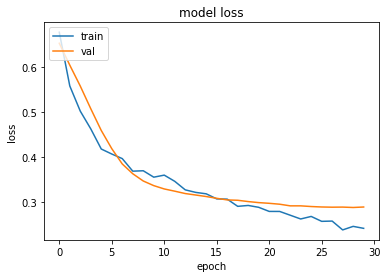

In [61]:
import matplotlib.pyplot as plt
plt.plot(historys[4]['loss'])
plt.plot(historys[4]['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [17]:
historys[4]['loss']

[0.6003360748291016,
 0.39249658584594727,
 0.27260082960128784,
 0.20907080173492432,
 0.16259503364562988,
 0.09351905435323715,
 0.10405447334051132,
 0.08963260799646378,
 0.21900108456611633,
 0.15422195196151733,
 0.07747237384319305,
 0.038994014263153076,
 0.03818773105740547,
 0.04631568491458893,
 0.03413725271821022,
 0.034633006900548935,
 0.03465097397565842,
 0.06722856312990189,
 0.06923086941242218,
 0.042484212666749954,
 0.024996832013130188,
 0.018310630694031715,
 0.008238214068114758,
 0.009727055206894875,
 0.014016089029610157,
 0.0065970211289823055,
 0.005025025922805071,
 0.005692292470484972,
 0.00446320790797472,
 0.005189503077417612]

In [18]:
historys[4]['val_loss']

[0.6843299865722656,
 0.8011519312858582,
 0.8471583724021912,
 1.1897672414779663,
 1.2004234790802002,
 1.1957978010177612,
 0.788483202457428,
 1.1862387657165527,
 0.5186746716499329,
 0.6088327765464783,
 0.7353946566581726,
 0.7120090126991272,
 0.8727397322654724,
 0.7315264940261841,
 0.7599920630455017,
 0.8403003811836243,
 0.8989680409431458,
 0.7093985080718994,
 0.8587856292724609,
 0.7403738498687744,
 0.8611348867416382,
 0.7187201976776123,
 0.8760604858398438,
 0.908010721206665,
 0.840823233127594,
 0.8675487637519836,
 0.9062723517417908,
 0.9102680683135986,
 0.9496763944625854,
 0.9356536865234375]

In [14]:
cough=0
nocough=0
for i in sup_DATA[1]['LABELS']:
    if i == 1:
        cough+=1
    else:
        nocough+=10
print(cough,nocough)

3442 2511


Num_samples: 288
acc:  0.9097222222222222


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 288
acc:  0.8854166666666666


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


Num_samples: 288
acc:  0.9236111111111112


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


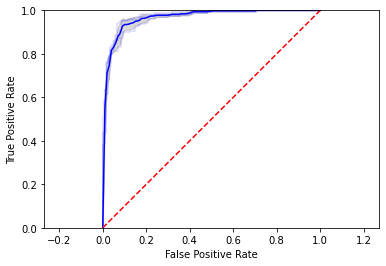

In [101]:
# Calculate ROC curves for each run
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from scipy import interp
import sklearn

# EDIT MODEL PATHS TO USE
models = {0: './model_1/0/*.hdf5',
          1: './model_1/1/*.hdf5',
          2: './model_1/2/*.hdf5',
          3: './model_1/3/*.hdf5',
          4: './model_1/4/*.hdf5'
          }

tprs = []
base_fpr = np.linspace(0, 1, 101)
for iii in range(3):
    test_imgs    = sup_DATA[iii]['MEL'][ int(0.7*sup_data_size): int(0.85*sup_data_size)]
    test_labels  = sup_DATA[iii]['LABELS'][ int(0.7*sup_data_size): int(0.85*sup_data_size)]
    TEST         = specGenerator(test_imgs,test_labels,batch_size=48,target_size=(64,64))
    path = './model_1/0'
#     for file in os.listdir(path):
#         model_path = path+'/'+file
#         model_path = path+'/'+file
    model = keras.models.load_model("./supervised_2000_1D/4/030--0.285--0.249.hdf5")
    y_score = model.predict(TEST)
    fpr, tpr, _ = roc_curve(test_labels[:len(y_score)], y_score)
    print('Num_samples:', len(y_score))
    print('acc: ', sklearn.metrics.accuracy_score(test_labels[:len(y_score)], y_score>0.7))

    plt.plot(fpr, tpr, 'b', alpha=0.15)
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axes().set_aspect('equal', 'datalim')
plt.savefig('roc_curve.png')
plt.show()

In [102]:
# Calculate ROC curves for each run
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from scipy import interp
import sklearn

def to_one_or_zero(bool):
    return 1 if bool else 0

for iii in range(3):
    print(iii)
    test_imgs    = sup_DATA[iii]['MEL'][ int(0.7*sup_data_size): int(0.85*sup_data_size)]
    test_labels  = sup_DATA[iii]['LABELS'][ int(0.7*sup_data_size): int(0.85*sup_data_size)]
    TEST         = specGenerator(test_imgs,test_labels,batch_size=48,target_size=(64,64))
#     for file in os.listdir(path):
#         model_path = path+'/'+file
#         model_path = path+'/'+file
    model = keras.models.load_model("./supervised_2000_1D/4/030--0.285--0.249.hdf5")
    y_score = model.predict(TEST)
    y_score = list(map(to_one_or_zero, y_score > .6))
 
    con_mat = tf.math.confusion_matrix(labels=test_labels[:len(y_score)], predictions=y_score).numpy()
    print(con_mat)

0
[[105  10]
 [ 10 163]]
1
[[115  14]
 [ 16 143]]
2
[[114   9]
 [ 10 155]]
